# MADMAX analysis pipeline & paper plots for the CB200 MORPURGO 2024 dataset

This notebook contains the code to reproduce the analysis pipeline and many of the plots of the MADMAX paper for the CB200 MORPURGO 2024 dataset (arXiv:2409.11777).
Note that the in-line display of the figures may slightly differ from the pdf version.

Activate and Instantiate the repository. Will only work if MADregistry is available for which a DESY account is required.

In [28]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Documents/Tests/CB200statana`


In [29]:
using PyPlot, PyCall
using DataFrames, NaNMath, Dates
using JLD2, HDF5
const nm = NaNMath
using StatsBase, Distributions
using MADbase, MADsearch

Update some Matplotlib settings to make the plots look better.

In [3]:
mpl = pyimport("mpl_toolkits.axes_grid1.inset_locator")
matplotlib = pyimport("matplotlib")
cmap = plt.get_cmap("Set1");
matplotlib.rc("savefig", dpi=300)
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "dejavuserif";

Note: Naming of the five dataruns is done either via starting day (e.g. phys21 comes from the physics-run started at 21st of February) or via the frequency of maximal peak factor (e.g. for phys21 this is max21= 18.531 GHz).

The relation is as follows:
- phys21 -> max21  = 18.531 GHz
- phys29 -> max29 = 18.543 GHz
- phys05 -> max05 = 18.557 GHz
- phys23 -> max23 = 19.215 GHz
- phys27 -> max27 = 19.196 GHz

Produce the data yourself... ToDo

## Plots from the MADMAX publication

For the plots of the publication the datasets below were used. Note: Your results may vary at the percent level due to some randomness introduced by the digital notch filter.

In [4]:
filterwindow = 1201

# Load physics data for individual physics-runs. These are preprocessed versions of the raw data. The Digital Notch filter has been applied, phys21 frequencies have been slightly adjusted and phys29 had a few bad timestamps removed.
phys23 = load("data_used_in_paper/data_phys.jld2")["phys23"]
phys27 = load("data_used_in_paper/data_phys.jld2")["phys27"]
phys21 = load("data_used_in_paper/data_phys.jld2")["phys21"]
phys29 = load("data_used_in_paper/data_phys.jld2")["phys29"]
phys05 = load("data_used_in_paper/data_phys.jld2")["phys05"]

# Load individual grand spectra for individual physics-runs
gg21 = load("data_used_in_paper/results_lowf.jld2")["gg21"]
gg29 = load("data_used_in_paper/results_lowf.jld2")["gg29"]
gg05 = load("data_used_in_paper/results_lowf.jld2")["gg05"]
gg23 = load("data_used_in_paper/results_highf.jld2")["gg23"]
gg27 = load("data_used_in_paper/results_highf.jld2")["gg27"]

# Load grand spectra and limits for both configurations
gghighf = load("data_used_in_paper/results_highf.jld2")["grand"]
gglowf =  load("data_used_in_paper/results_lowf.jld2")["grand"]
guhighf = load("data_used_in_paper/results_highf.jld2")["uncertainty"]
gulowf =  load("data_used_in_paper/results_lowf.jld2")["uncertainty"]
llhighf = load("data_used_in_paper/results_highf.jld2")["limit"]
lllowf =  load("data_used_in_paper/results_lowf.jld2")["limit"];

Read boost factor samples

In [5]:
beta21 = read_beta(phys21, "data_input/bres_combined.jld2", "2024-02-21_overnight")
beta23 = read_beta(phys23, "data_input/bres_combined.jld2", "2024-02-23_weekend")
beta27 = read_beta(phys27, "data_input/bres_combined.jld2", "2024-02-27_magnettest")
beta29 = read_beta(phys29, "data_input/bres_combined.jld2", "2024-02-29_broadband")
beta05 = read_beta(phys05, "data_input/bres_combined.jld2", "2024-03-05_overnight")

# These values can be easily extracted from the data. They are hard coded here since they are necessary for a few of the plots.
max21 = 18.531 
max23 = 19.215
max27 = 19.196
max29 = 18.543
max05 = 18.557

betadict = Dict()
nn = ["beta21", "beta29", "beta05", "beta27", "beta23"]
for (i, beta) in enumerate([beta21, beta29, beta05, beta27, beta23])
    betadict[nn[i]] = DataFrame(f=beta.f)
    betadict[nn[i]][!, :mean] = get_beta(beta; method="mean")[!,2]
    betadict[nn[i]][!, :m1sig] = get_beta(beta; method=0.16)[!,2]
    betadict[nn[i]][!, :p1sig] = get_beta(beta; method=0.84)[!,2]
end

ηSG and σf can be obtained from simulations, which were performed separatel for all physics-runs. The values used in the analysis below are obtained from the files available on the MADMAX dCache by using the most conservative values among the five physics-runs.

In [6]:
ηSG = 0.945417
σf  = 0.958408;

The functions below help with plotting.

In [7]:
function MADMAX_inset(ax; preliminary=false, loc=[-0.01,0.92,0.25,0.25])
    arr_image = plt.imread("MadMax-Logo_RGB-grau-orange.png", format="png")
    
    # Draw image
    axin = ax.inset_axes(loc)    # create new inset axes in data coordinates
    axin.imshow(arr_image)
    if preliminary
        axin.text(0.98, 0.45, "Preliminary", fontsize=10, color="k", ha="left", va="center", transform=axin.transAxes)
    end
    axin.axis("off")
end

function plot_hist!(ax_hist, grand_spectrum; nbins=40)
    goodvals = .!isnan.(grand_spectrum.grand)
    nn = fit(Normal, grand_spectrum.grand[goodvals])
    myh = fit(Histogram, grand_spectrum.grand[goodvals], nbins=nbins)

    ax_hist.scatter(myh.weights , myh.edges[1][1:end-1] .+ 0.5 * diff(myh.edges[1]), ls="None", c=c1, alpha=1, marker="x") # ./ sum(myh.weights) ./ diff(myh.edges[1])
    ax_hist.set_xscale("log")
    ax_hist.plot(pdf.(nn, collect(-4.1:0.1:4.1)) .* sum(myh.weights) .* mean(diff(myh.edges[1])), collect(-4.1:0.1:4.1), lw=1, c=c1, alpha=1)
    #ax1.legend(loc="lower left", fontsize=9.1)
    if round(nn.μ, digits=2) != 0.0
        @error "Your value for mean of the distribution is wrong"
    end
    ax_hist.text(0.1, 0.505, latexstring("\$\\mu = {0.00}\$\n\$\\sigma =  $(round(nn.σ, digits=2))\$"), size=11, transform=ax_histy.transAxes, bbox=Dict("facecolor"=>"white", "alpha"=>0.9, "edgecolor"=>"black", "boxstyle"=>"round"))

    ax_hist.set_xlabel("Counts", fontsize=12)
    ax_hist.set_xlim((1.5, 0.9e4))
    ax_hist.minorticks_off()
    ax_hist.grid(visible=true, color="lightgrey", lw=0.1)
end

function set_plotparams!(ax)
    ax.set_xlabel("Frequency [GHz]", fontsize=12)
    ax.set_ylabel("Normalized power excess", fontsize=12)
    ax.set_yticks([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])
    ax.set_ylim((-6.9, 5.7))
    ax.grid(visible=true, color="lightgrey", lw=0.1)
end;

In [8]:
function tick_function(X)
    V = X .* 1e-9
    return  ["$(round(z; digits=2))" for z in V]
end

function construct_freq_axis(ax, freqticks)
    axf = ax.twiny()
    new_tick_locations = mass.(freqticks) .* 1e6#[.2, 10.5, 50.9]

    axf.set_xlim(ax.get_xlim())
    axf.set_xticks(new_tick_locations)
    axf.set_xticklabels(tick_function(freqticks))
    return axf
end

function set_plot_params_CB200_configurations!(ax1, ax2; xstart=[76.54, 79.27])
    ax1.set_xlabel(L"Axion Mass $m_a$ [$\mathrm{\mu}$eV]")
    ax1.xaxis.set_label_coords(1.02, -0.11)
    ax1.set_xlim((xstart[1], xstart[1]+0.3))
    ax2.set_xlim((xstart[2], xstart[2]+0.3))

    ax1.spines.right.set_visible(false)
    ax2.spines.left.set_visible(false)
    ax2.yaxis.set_visible(false)
    ax2.tick_params(labelright=false)

    ax3 = construct_freq_axis(ax1, [18.51e9, 18.53e9, 18.55e9, 18.57e9])
    ax3.set_xlabel("Frequency [GHz]")
    ax3.xaxis.set_label_coords(1.02, 1.12)
    ax3.spines.right.set_visible(false)

    ax4 = construct_freq_axis(ax2, [19.17e9, 19.19e9, 19.21e9, 19.23e9])
    ax4.spines.left.set_visible(false)

    # Plot dashes indicating gap in x axes
    d = 0.015
    ax1.plot([1-d, 1+d], [-d, d],transform=ax1.transAxes, color="k", clip_on=false)
    ax1.plot([1-d, 1+d], [1-d, 1+d],transform=ax1.transAxes, color="k", clip_on=false)
    ax2.plot([-d, +d], [-d, d], transform=ax2.transAxes, color="k", clip_on=false)
    ax2.plot([-d, +d], [1-d, 1+d], transform=ax2.transAxes, color="k", clip_on=false)
end;

### Plot boostfactors (Paper Fig.2)

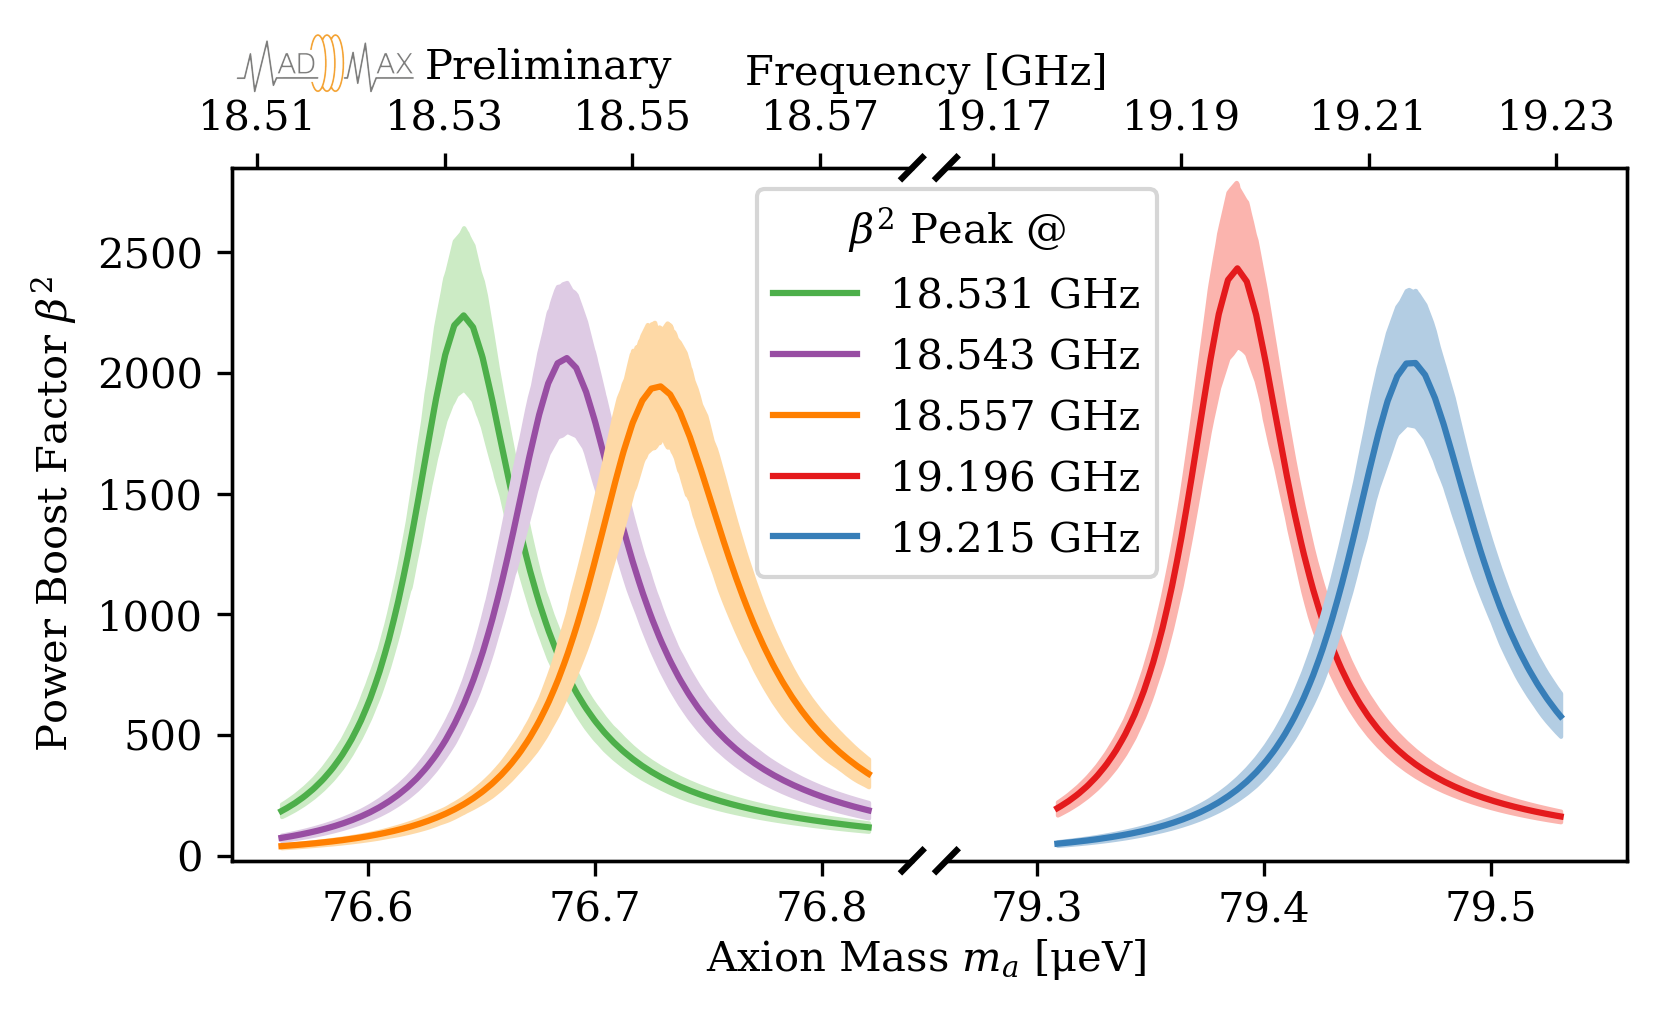

In [9]:
cmap = plt.get_cmap("Pastel1");
cmap2 = plt.get_cmap("Set1");

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
fig.subplots_adjust(wspace=0.05)
mhf = mass.(beta23.f) .* 1e6
mlf = mass.(beta21.f) .* 1e6

ax2.fill_between(mhf[1:20:end], betadict["beta27"].m1sig[1:20:end].^2, betadict["beta27"].p1sig[1:20:end].^2, alpha=1, label="", color=cmap(0), zorder=1)
ax2.plot(mhf[1:20:end], betadict["beta27"].mean[1:20:end].^2, label="$max27 GHz", color=cmap2(0), zorder=1)
ax2.fill_between(mhf[1:20:end], betadict["beta23"].m1sig[1:20:end].^2, betadict["beta23"].p1sig[1:20:end].^2, alpha=1, label="", color=cmap(1), zorder=2)
ax2.plot(mhf[1:20:end], betadict["beta23"].mean[1:20:end].^2, label="$max23 GHz", color=cmap2(1), zorder=2)

ax1.fill_between(mlf[1:20:end], betadict["beta21"].m1sig[1:20:end].^2, betadict["beta21"].p1sig[1:20:end].^2, alpha=1, label="", color=cmap(2), zorder=1)
ax1.plot(mlf[1:20:end], betadict["beta21"].mean[1:20:end].^2, label="$max21 GHz", color=cmap2(2), zorder=1)
ax1.fill_between(mlf[1:20:end], betadict["beta29"].m1sig[1:20:end].^2, betadict["beta29"].p1sig[1:20:end].^2, alpha=1, label="", color=cmap(3), zorder=1.5)
ax1.plot(mlf[1:20:end], betadict["beta29"].mean[1:20:end].^2, label="$max29 GHz", color=cmap2(3), zorder=1.5)
ax1.fill_between(mlf[1:20:end], betadict["beta05"].m1sig[1:20:end].^2, betadict["beta05"].p1sig[1:20:end].^2, alpha=1, label="", color=cmap(4), zorder=2)
ax1.plot(mlf[1:20:end], betadict["beta05"].mean[1:20:end].^2, label="$max05 GHz", color=cmap2(4), zorder=2)

h, l = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(vcat(h, h2),vcat(l, l2), loc="lower right", bbox_to_anchor=(0.34, 0.38), title=L"$\beta^2$ Peak @")
ax1.set_ylabel(L"Power Boost Factor $\beta^2$")
ax1.set_ylim((-20, 2850))
ax2.set_ylim((-20, 2850))

set_plot_params_CB200_configurations!(ax1, ax2; xstart=[76.54, 79.26])
MADMAX_inset(ax1; preliminary=true, loc=[-0.01,1.0,0.3,0.3])

plt.savefig("plots/boostfactors.pdf", bbox_inches="tight")
display(fig)

Calculate the strength of a reference signal to include in the plot for the low-frequency configuration:

In [10]:
EoN = 2240.92
maxf = gglowf.f[gglowf.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]) .== nm.maximum(gglowf.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]))]
th = SeedTheory(ma=mass(maxf[1])*1e6, EoverN=EoN, σ_v=220.0/sqrt(2))
ex = SeedExperiment(gglowf.f)
sig = signal_power_per_bin.(gglowf.f, Ref(th), Ref(ex))
dummy_combined_spectrum = DataFrame(spectrum=sig, binwise_std=ones(length(sig)), f=gglowf.f)
siggg = get_grand_spectrum(dummy_combined_spectrum)
siggg.grand .*= nm.maximum(gglowf.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234])) ./ nm.maximum(siggg.grand);

### Plot grand spectrum for low frequency configuration (Paper Fig. 3, upper)

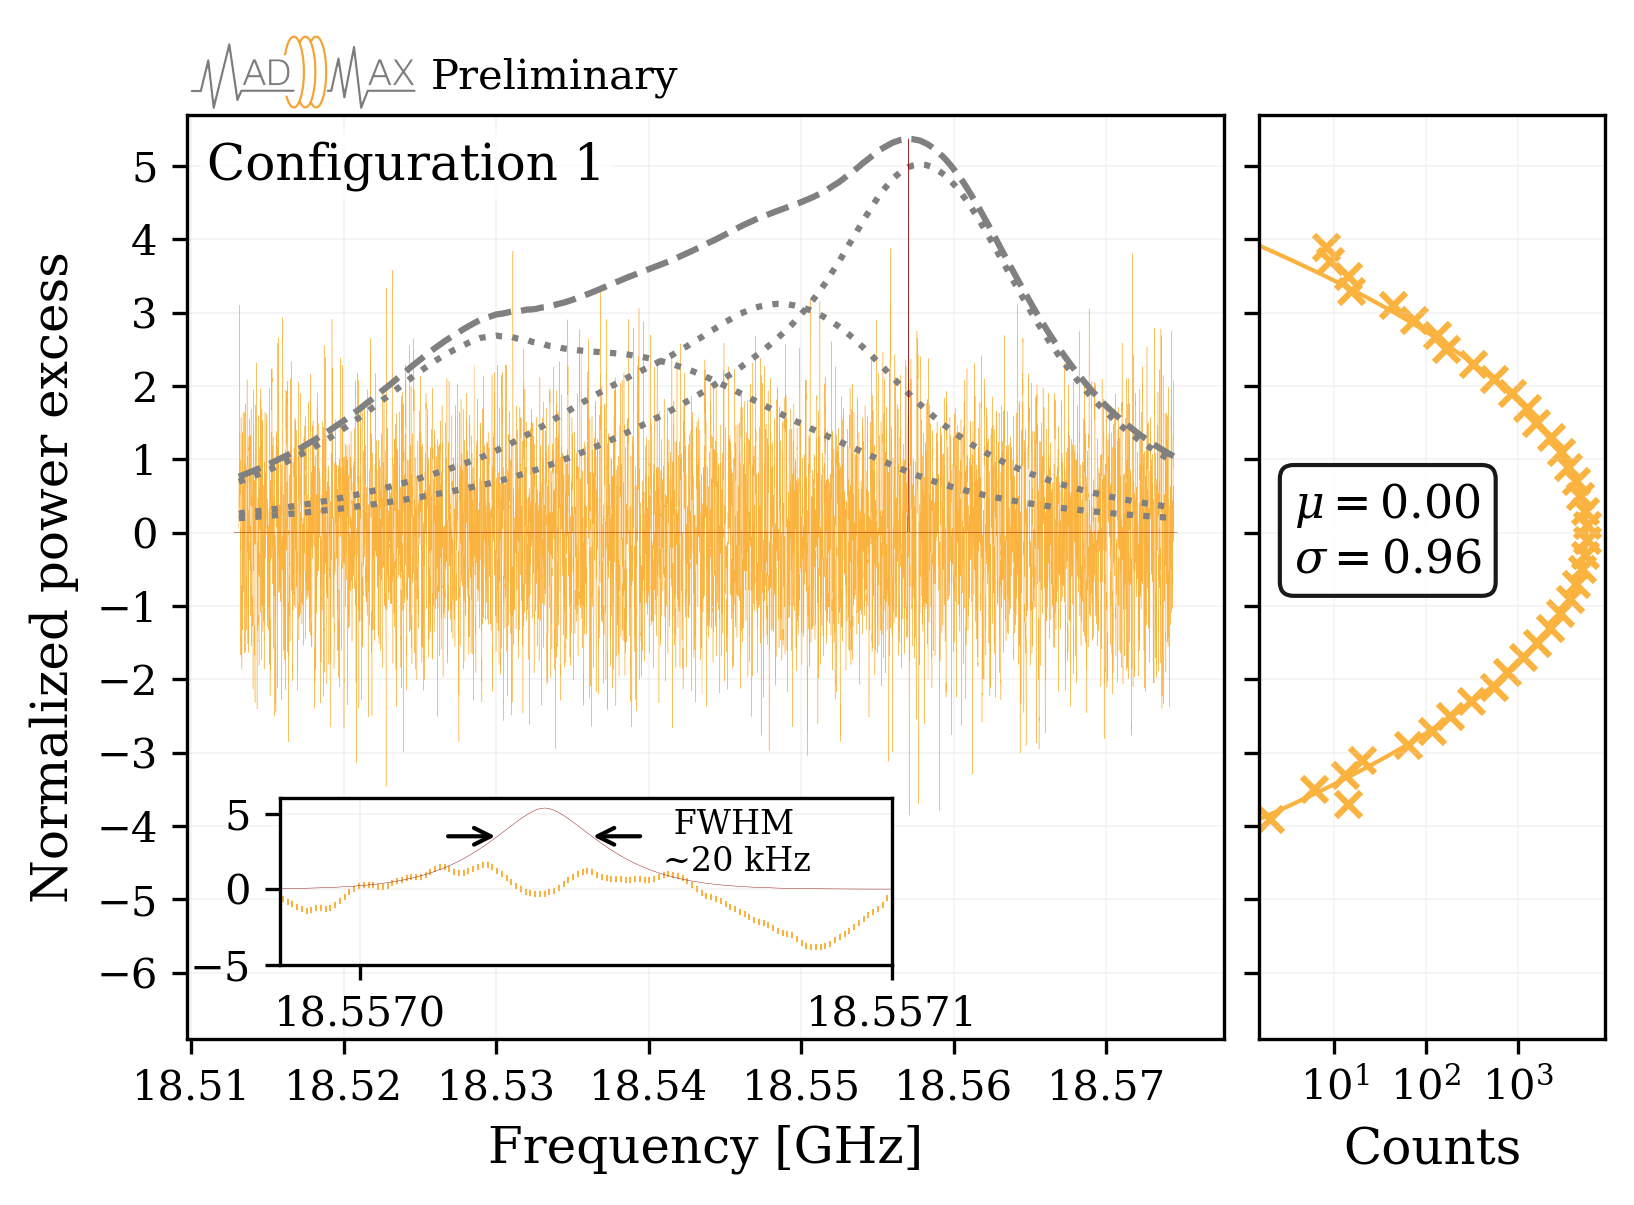

In [11]:
c1 = "#fbb33f"
EoN = 2240.92

fig, (ax1, ax_histy) = plt.subplots(1, 2, figsize=(6.1, 4), sharey=true, width_ratios=[3, 1], gridspec_kw=Dict("wspace"=>0.05))
ax1.plot(gglowf.f ./ 1e9, gglowf.grand; color=c1, label="data", lw=0.1)
ax1.plot(gglowf.f ./ 1e9, gglowf.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]); color="gray", ls="dashed", label=L"sig. amplitudes for $|g_{a\gamma}^\mathrm{ref}| = 3.5\times 10^{-11}\,\mathrm{GeV}^{-1}$")
ax1.plot(gg21.f ./ 1e9, gg21.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]); color="grey", ls="dotted", label="same for individual physics-runs")
ax1.plot(gg29.f ./ 1e9, gg29.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]); color="grey", ls="dotted", label="")
ax1.plot(gg05.f ./ 1e9, gg05.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234]); color="grey", ls="dotted", label="")
ax1.text(0.02, 0.93, "Configuration 1", transform=ax1.transAxes, fontsize=12, bbox=Dict("facecolor"=>"white", "alpha"=>0.7, "edgecolor"=>"white", "boxstyle"=>"round", "pad"=>0.1))
zoom = ax1.inset_axes([0.09,0.08,0.59,0.18])    # create new inset axes in data coordinates
zoom.scatter(gglowf.f ./ 1e9, gglowf.grand; color=c1, s=0.1, marker="_")
zoom.plot(siggg.f ./ 1e9, siggg.grand; color="darkred", lw=0.1, label=L"expected signal shape with $|g_{a\gamma}^\mathrm{ref}| = 3.5\times 10^{-11}\,\mathrm{GeV}^{-1}$")
ax1.plot(siggg.f[234:end-234] ./ 1e9, siggg.grand[234:end-234]; color="darkred", lw=0.1)
zoom.set_xlim((18.556985, 18.5571))
zoom.set_ylim((-5,6))
zoom.set_xticks([18.557, 18.5571])
zoom.annotate("", xy=(18.557027, 3.5), xytext=(18.557015, 3.5), arrowprops=Dict("arrowstyle" => "->"), zorder=100)
zoom.annotate("", xy=(18.5570422, 3.5), xytext=(18.5570542, 3.5), arrowprops=Dict("arrowstyle" => "->"), zorder=100)
zoom.text(18.557057, 1.2, " FWHM\n~20 kHz", fontsize=8, color="k")
zoom.grid(visible=true, color="lightgrey", lw=0.1)
zoom.set_xticklabels(["18.5570", "18.5571"])

set_plotparams!(ax1)
plot_hist!(ax_histy, gglowf; nbins=40)
MADMAX_inset(ax1; preliminary=true)

plt.savefig("plots/grandspectrum_lowf.pdf", bbox_inches="tight")
display(fig)

### Plot grand spectrum for high frequency configuration (Paper Fig. 3, lower)

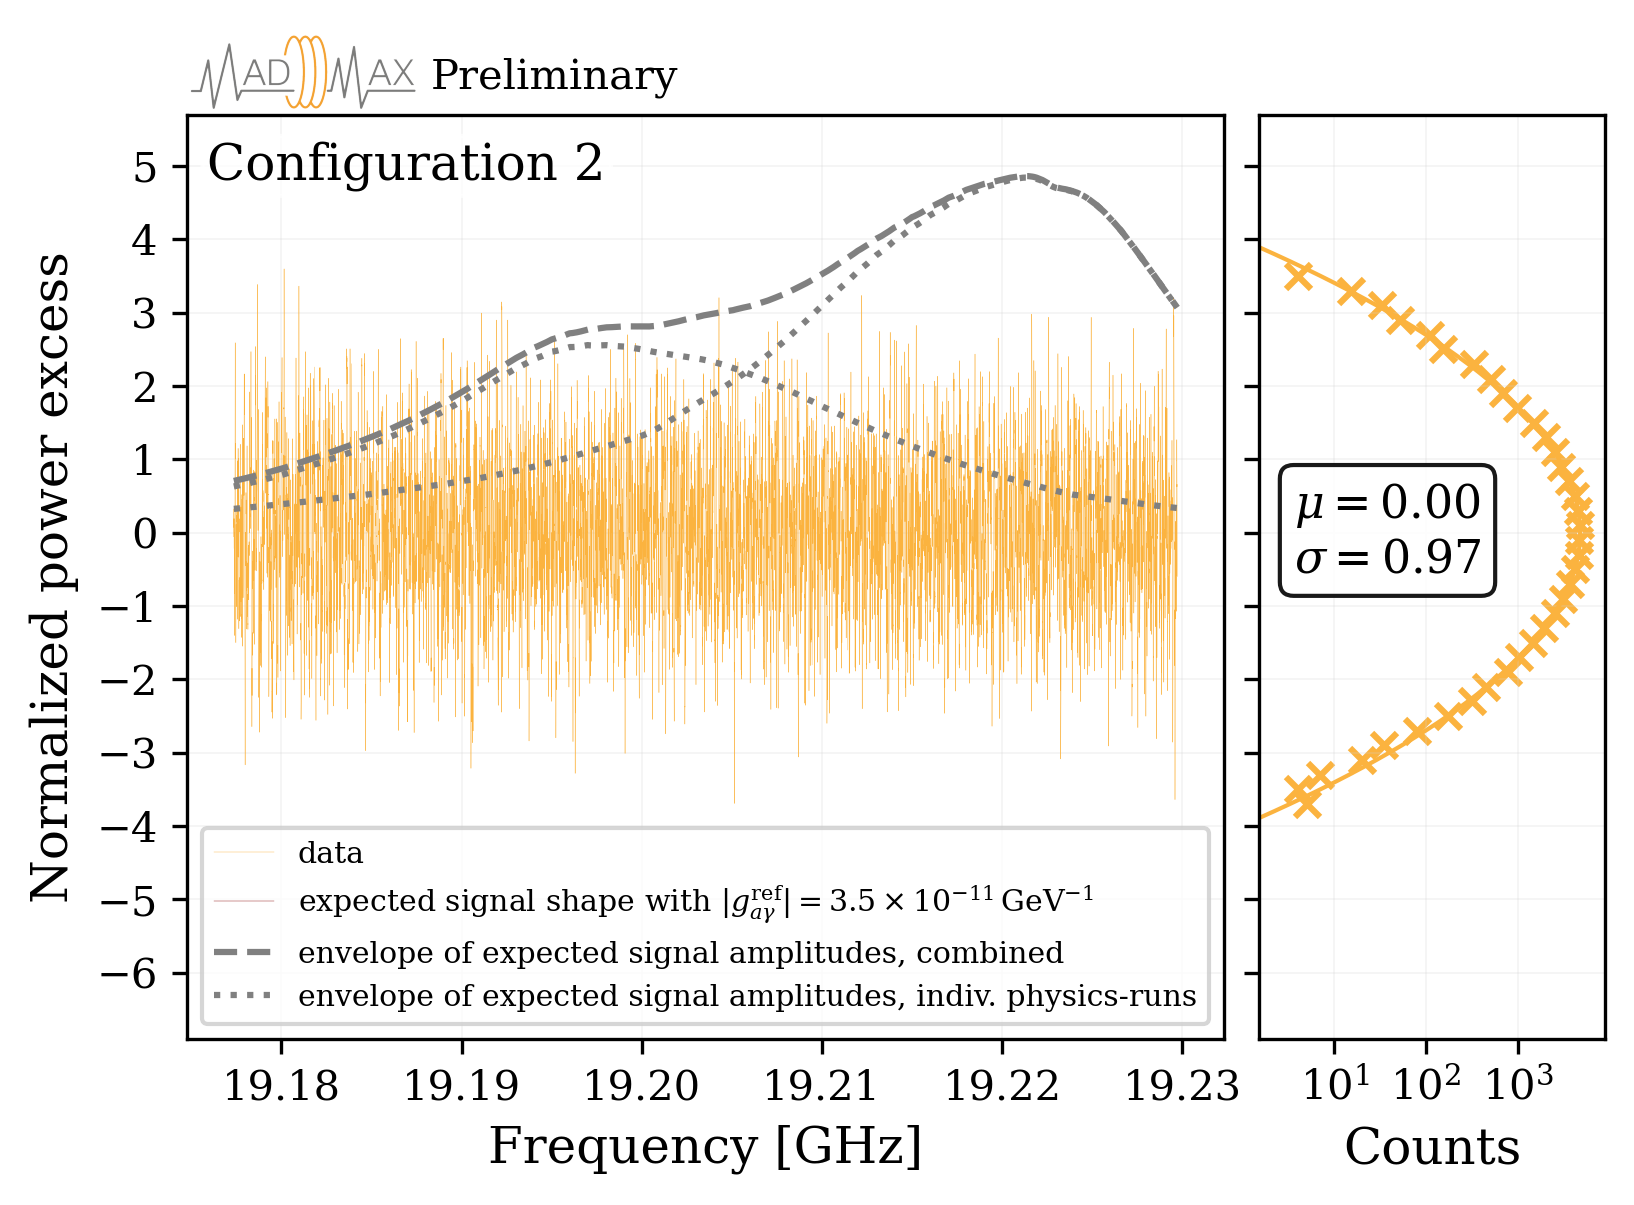

In [12]:
zh1, zl1 = zoom.get_legend_handles_labels()
c1 = "#fbb33f"
EoN = 2165.92

fig, (ax1, ax_histy) = plt.subplots(1, 2, figsize=(6.1, 4), sharey=true, width_ratios=[3, 1], gridspec_kw=Dict("wspace"=>0.05))
ax1.plot(gghighf.f ./ 1e9, gghighf.grand; color=c1, label="data", lw=0.1)
ax1.plot(gghighf.f ./ 1e9, gghighf.Rg .* (EoN/400.92)^2 .* (1 .- guhighf[1:end-234]); color="gray", ls="dashed", label="envelope of expected signal amplitudes, combined")
ax1.plot(gg27.f ./ 1e9, gg27.Rg .* (EoN/400.92)^2 .* (1 .- guhighf[1:end-234]); ls="dotted", label="envelope of expected signal amplitudes, indiv. physics-runs", color="gray")
ax1.plot(gg23.f ./ 1e9, gg23.Rg .* (EoN/400.92)^2 .* (1 .- guhighf[1:end-234]); ls="dotted", label="", color="gray")
ax1.text(0.02, 0.93, "Configuration 2", transform=ax1.transAxes, fontsize=12, bbox=Dict("facecolor"=>"white", "alpha"=>0.7, "edgecolor"=>"white", "boxstyle"=>"round", "pad"=>0.1))
h0, l0 = ax1.get_legend_handles_labels()
ax1.legend(loc="lower left", fontsize=7.2, handles=vcat(h0[1], zh1, h0[2:end]), labels=vcat(l0[1], zl1, l0[2:end])) 

set_plotparams!(ax1)
plot_hist!(ax_histy, gghighf; nbins=35)
MADMAX_inset(ax1; preliminary=true)

plt.savefig("plots/grandspectrum_highf.pdf", bbox_inches="tight")
display(fig)


### Plot final exclusion limit (Paper Fig. 4)

Generate the median and 1 sigma limit lines. This produces warnings, ignore them, it's fine.

In [13]:
cl = 0.95
zero_spectrum = deepcopy(gghighf)
zero_spectrum.grand = zeros(length(zero_spectrum.grand))
mone_spectrum = deepcopy(gghighf)
mone_spectrum.grand = -1. .* ones(length(mone_spectrum.grand))
pone_spectrum = deepcopy(gghighf)
pone_spectrum.grand = ones(length(pone_spectrum.grand))
limit_median_hf = MADMAX_axion_search(zero_spectrum; Rg_uncertainty=guhighf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
limit_m1s_hf = MADMAX_axion_search(mone_spectrum; Rg_uncertainty=guhighf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
limit_p1s_hf = MADMAX_axion_search(pone_spectrum; Rg_uncertainty=guhighf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
unchf_effect = MADMAX_axion_search(mone_spectrum; cut_sigma=-1.0, ηSG=ηSG, cl=cl)
zero_spectrum = deepcopy(gglowf)
zero_spectrum.grand = zeros(length(zero_spectrum.grand))
mone_spectrum = deepcopy(gglowf)
mone_spectrum.grand = -1. .* ones(length(mone_spectrum.grand))
pone_spectrum = deepcopy(gglowf)
pone_spectrum.grand = ones(length(pone_spectrum.grand))
limit_median_lf = MADMAX_axion_search(zero_spectrum; Rg_uncertainty=gulowf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
limit_m1s_lf = MADMAX_axion_search(mone_spectrum; Rg_uncertainty=gulowf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
limit_p1s_lf = MADMAX_axion_search(pone_spectrum; Rg_uncertainty=gulowf[1:end-234], cut_sigma=-1.0, ηSG=ηSG, cl=cl);
unclf_effect = MADMAX_axion_search(mone_spectrum; cut_sigma=-1.0, ηSG=ηSG, cl=cl);

┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning: Your limit has probably not been normalized. Result will be wrong!
└ @ MADsearch /Users/diehl/.julia/packages/MADsearch/HcCBv/src/combine_spectrum.jl:451
┌ Warning:

Competing limits:

In [14]:
# All values taken from Ciaran's repository (https://github.com/cajohare/AxionLimits)

# SN1987 gamma rays (arXiv:2405.19393)
SNgamma = [64.8899594221391 3.626989629312025e-11; 84.2745795393751 4.5285027038008055e-11]
# NuSTAR (arXiv:2407.03828)
Nustar = [65.1055733078653 2.7131754070089416e-11; 76.7851934299400 2.934402083252259e-11; 90.5600800440382 3.1726393349766435e-11];
# CAST limit (arXiv:2406.16840)
CAST = 5.7e-11
# Globular Cluster limit (arXiv:2207.03102)
globcluster = 4.7e-11;

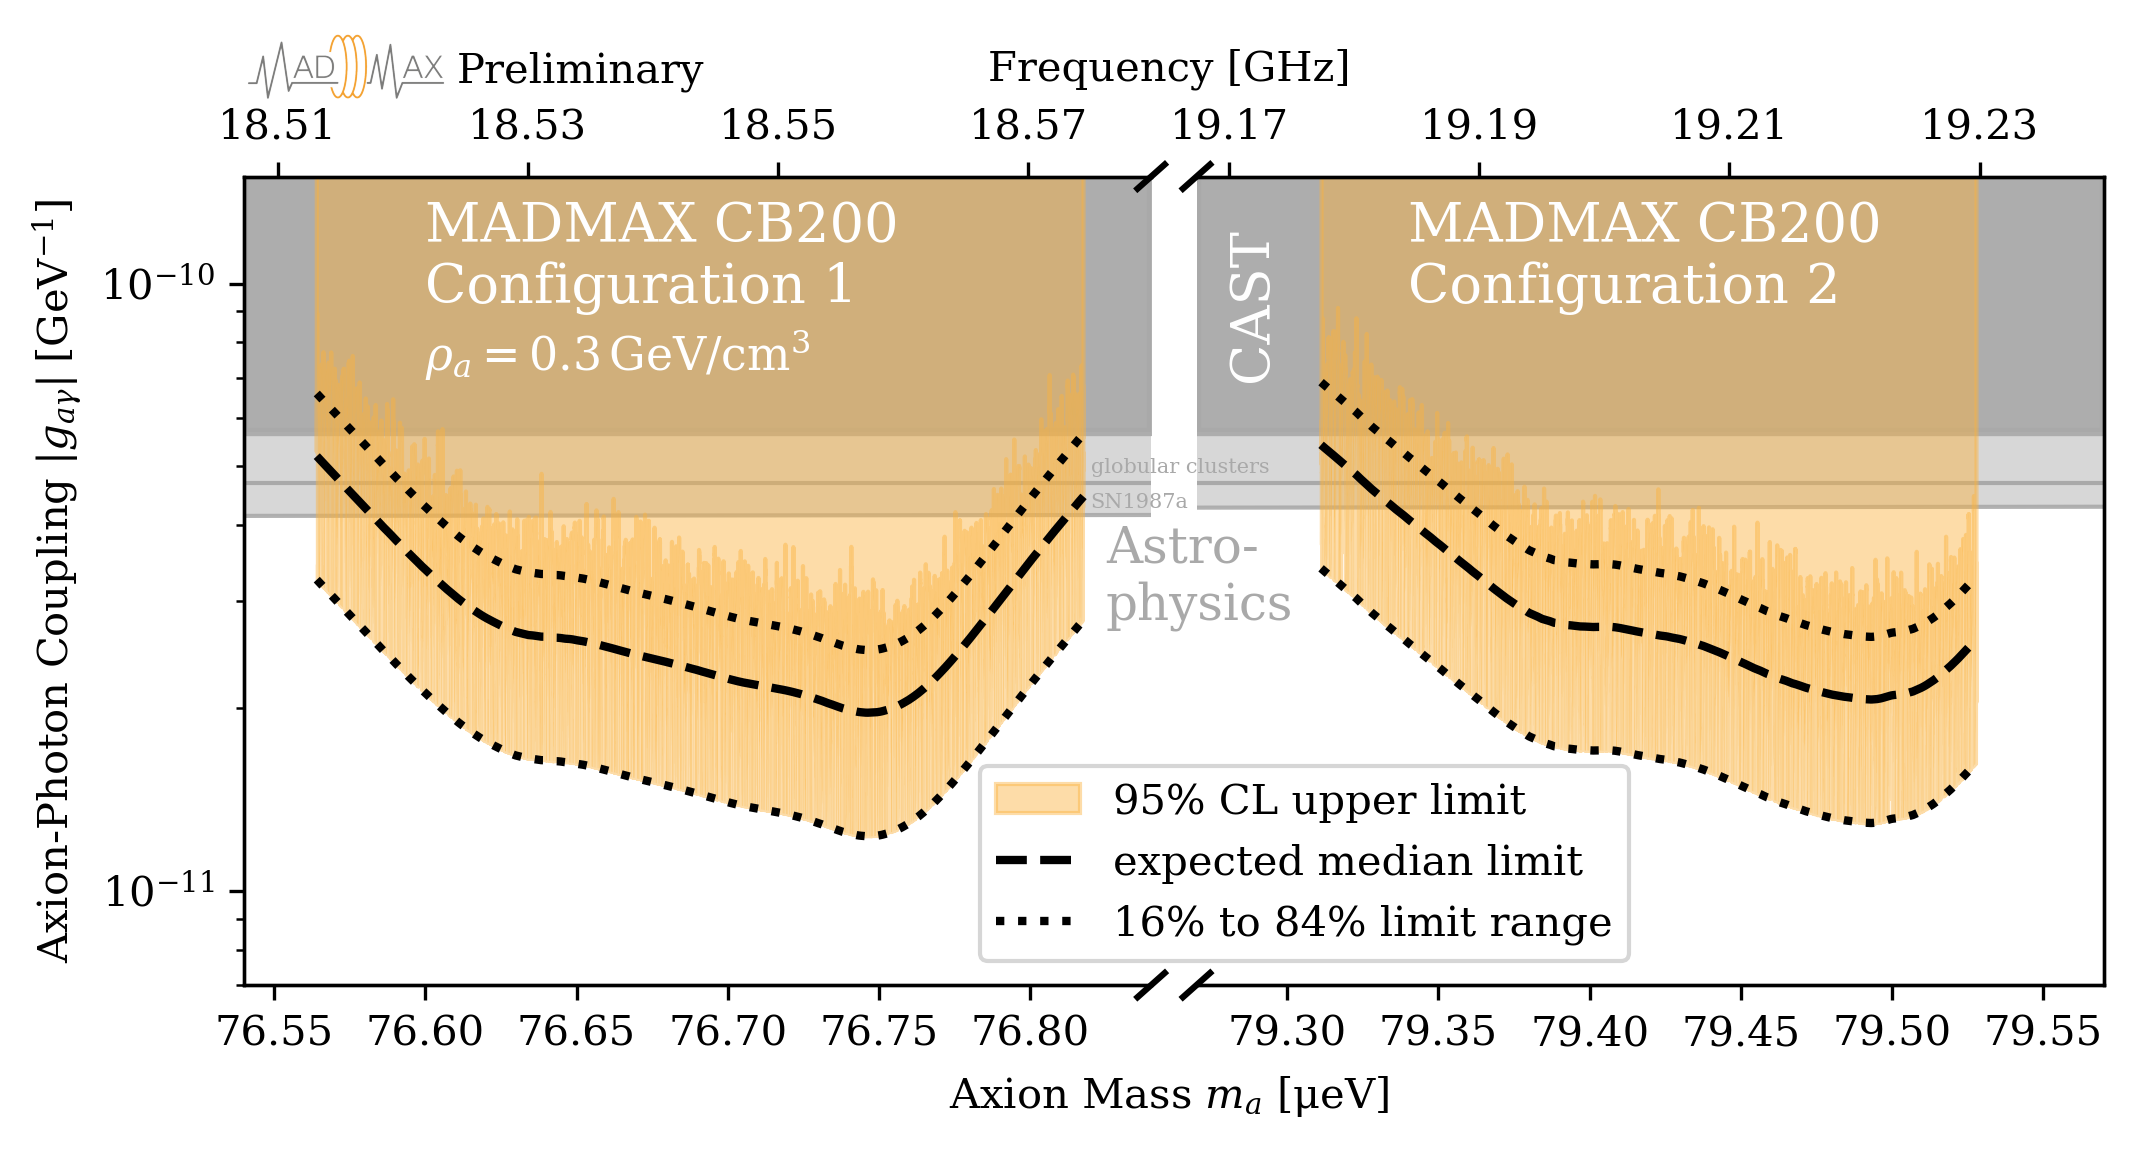

In [15]:
c1 = "#fbb33f"
c2="k"
ccast = "darkgrey"#"#8f8f8e"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
fig.subplots_adjust(wspace=0.05)
mhf = mass.(gghighf.f) .* 1e6
mlf = mass.(gglowf.f) .* 1e6

# Plot data
ax2.fill_between(mhf, llhighf .* 1e9, 1e-9, alpha=0.45, label="95% CL upper limit", color=c1)
ax1.fill_between(mlf, lllowf .* 1e9, 1e-9, alpha=0.45, label="95% CL upper limit", color=c1)
ax2.plot(mhf, llhighf .* 1e9; color=c1, lw=0.01)
ax1.plot(mlf, lllowf.* 1e9, label="", color=c1, lw=0.01)

# Plot reference lines
ax2.plot(mhf, limit_median_hf .* 1e9, lw=2, alpha=1, color=c2, ls=:dashed, label="expected median limit")
ax2.plot(mhf, limit_m1s_hf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="16% to 84% limit range")
ax2.plot(mhf, limit_p1s_hf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="")
ax1.plot(mlf, limit_median_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dashed, label="expected median limit")
ax1.plot(mlf, limit_m1s_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="16% to 84% limit range")
ax1.plot(mlf, limit_p1s_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="")

ax2.legend(loc="upper right", bbox_to_anchor=(0.50,0.297))
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"Axion-Photon Coupling $|g_{a\gamma}|\;[\mathrm{GeV}^{-1}]$")
ax1.set_ylim((0.7e-11, 0.15e-9))
ax2.set_ylim((0.7e-11, 0.15e-9))

# Plot competing limits
ax1.fill_between([76.54, 76.54+0.3], CAST, 1e-9, alpha=0.9, label="CAST", lw=2, color=ccast, zorder=0.12)
ax2.fill_between([79.27, 79.27+0.3], CAST, 1e-9, alpha=0.9, label="", ls="-", lw=2, color=ccast, zorder=0.12)
ax1.plot([76.54, 76.54+0.3], [globcluster, globcluster], label="", lw=1, color=ccast, zorder=0.11)
ax2.plot([79.27, 79.27+0.3], [globcluster, globcluster], label="", lw=1, color=ccast, zorder=0.11)
ax2.fill_between(SNgamma[:,1], SNgamma[:,2], 1e-9, lw=1, color="lightgray", alpha=0.9, label="SN1987A", zorder=0.1, ec=ccast)
ax1.fill_between(SNgamma[:,1], SNgamma[:,2], 1e-9, lw=1, color="lightgray", alpha=0.9, label="SN1987A", zorder=0.1, ec=ccast)
#ax2.fill_between(Nustar[:,1], Nustar[:,2], 1e-9, lw=1, color="lightgray", alpha=0.9, label="NuSTAR", zorder=0.1, ec=ccast)
#ax1.fill_between(Nustar[:,1], Nustar[:,2], 1e-9, lw=1, color="lightgray", alpha=0.9, label="NuSTAR", zorder=0.1, ec=ccast)
ax2.text(79.28, 0.72e-10, "CAST", fontsize=13, c=:white, rotation="vertical")
ax2.text(79.235, 0.489e-10, "globular clusters", fontsize=5, c=ccast, alpha=1) # \times \sqrt{0.3\; \mathrm{GeV} / \mathrm{cm}³}
ax2.text(79.235, 0.428e-10, "SN1987a", fontsize=5, c=ccast, alpha=1)
ax2.text(79.24, 0.28e-10, "Astro-\nphysics", fontsize=12, c=ccast, alpha=1)
#ax2.text(79.245, 0.24e-10, "NuSTAR", fontsize=11, c=:gray, alpha=0.7)
ax1.text(76.6, 0.093e-9, "MADMAX CB200\nConfiguration 1", fontsize=13, c=:white)
ax1.text(76.6, 0.72e-10, L"\rho_a = 0.3\,\mathrm{GeV}/\mathrm{cm}^3", fontsize=11, c=:white)
ax2.text(79.34, 0.093e-9, "MADMAX CB200\nConfiguration 2", fontsize=13, c=:white)

set_plot_params_CB200_configurations!(ax1, ax2)
MADMAX_inset(ax1; preliminary=true, loc=[-0.01,1.01,0.25,0.25])

plt.savefig("plots/limit.pdf", bbox_inches="tight", dpi=300)
display(fig)

## Appendix Plots

### Plot overview of available magnetic field strength over time (Paper Fig. S2)

In [16]:
r = load_datarun("data_input/reduced-data-mean100.h5")
B = get_B_data(r)
# Something seems to be wrong with our sensor...
B[!, "B [T]"] .= abs.(B[!, "B [T]"]);

┌ Warning: No version specified in run file! Can't judge compatibility with current version: 0.2.0.
└ @ MADbase /Users/diehl/.julia/packages/MADbase/7Vveq/src/data_utils.jl:67


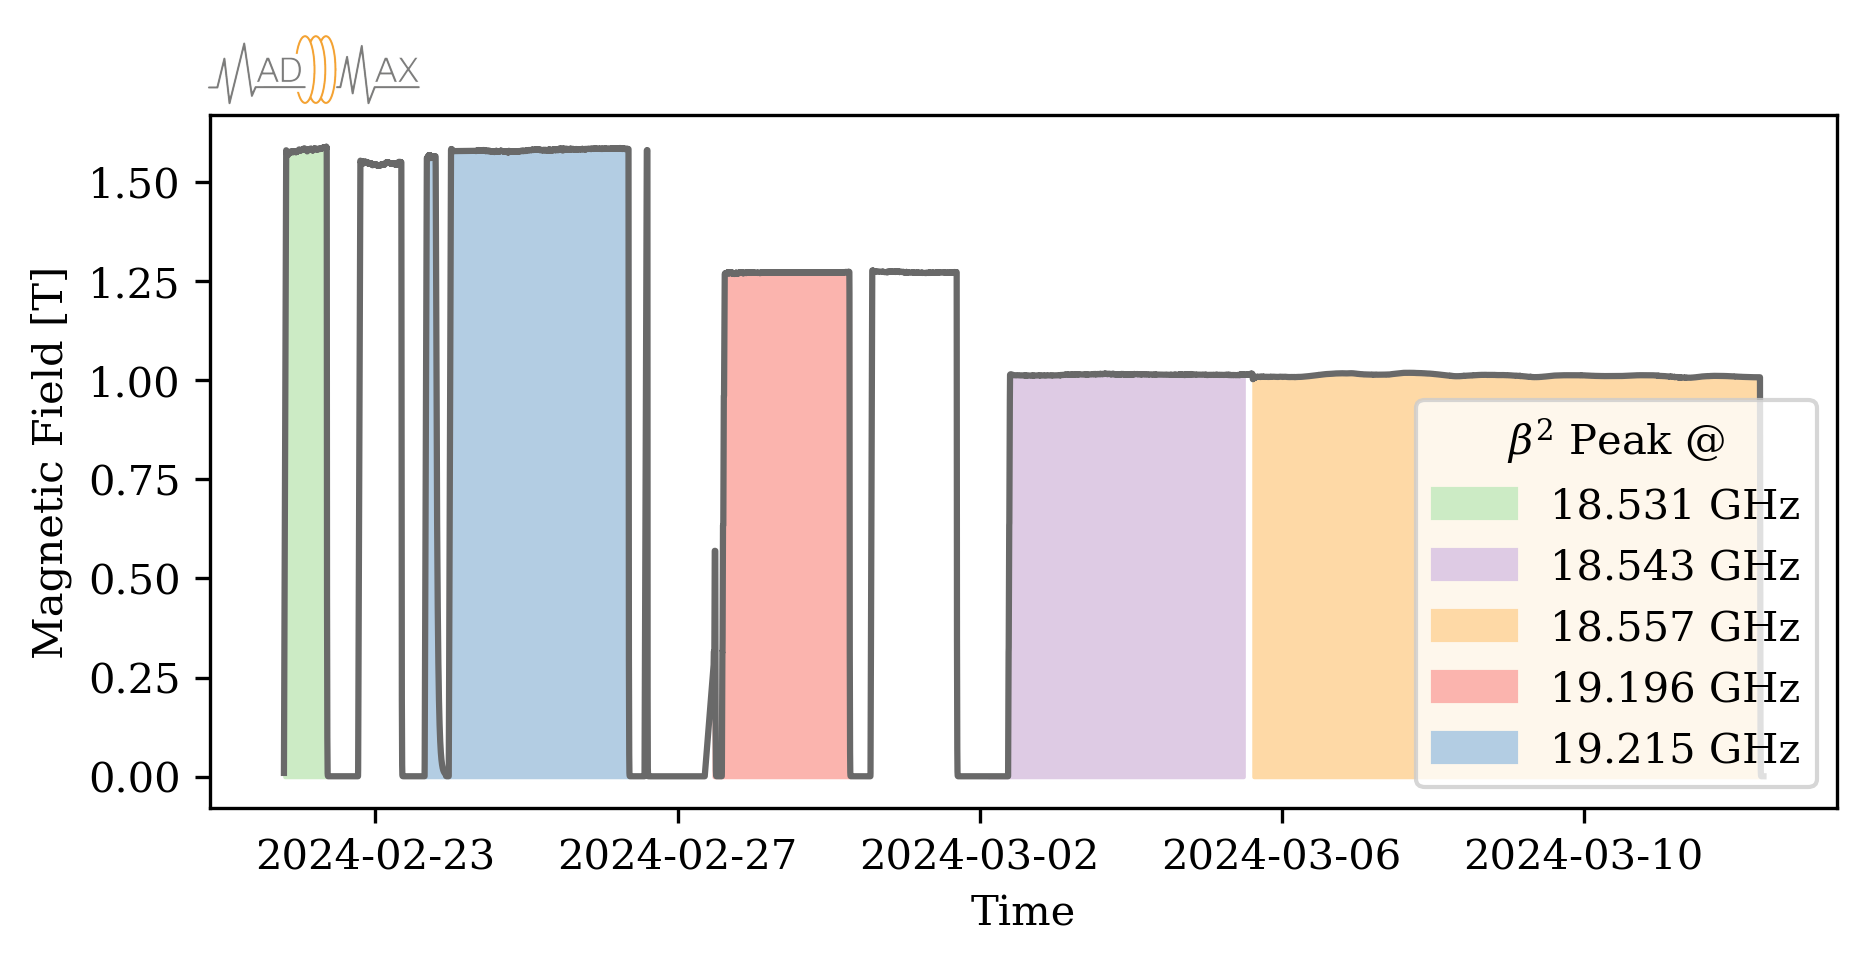

In [17]:
cmap = plt.get_cmap("Pastel1");

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
ax.plot(DateTime.(B.DateTime[1:10:end]), abs.(B[1:10:end, "B [T]"]), color="dimgray")
ax.fill_between(DateTime.(B.DateTime[1:10:end]), 0, abs.(B[1:10:end, "B [T]"]), where=DateTime(first(names(phys21[!,Not(:f)]))) .<= DateTime.(B.DateTime[1:10:end]) .<= DateTime(last(names(phys21[!,Not(:f)]))), alpha=1, color=cmap(2), label="$max21 GHz")
ax.fill_between(DateTime.(B.DateTime[1:10:end]), 0, abs.(B[1:10:end, "B [T]"]), where=DateTime("2024-03-02T02:44:43") .<= DateTime.(B.DateTime[1:10:end]) .<= DateTime(last(names(phys29[!,Not(:f)]))), alpha=1, color=cmap(3), label="$max29 GHz")
ax.fill_between(DateTime.(B.DateTime[1:10:end]), 0, abs.(B[1:10:end, "B [T]"]), where=DateTime(first(names(phys05[!,Not(:f)]))) .<= DateTime.(B.DateTime[1:10:end]) .<= DateTime(last(names(phys05[!,Not(:f)]))), alpha=1, color=cmap(4), label="$max05 GHz")
ax.fill_between(DateTime.(B.DateTime[1:10:end]), 0, abs.(B[1:10:end, "B [T]"]), where=DateTime(first(names(phys27[!,Not(:f)]))) .<= DateTime.(B.DateTime[1:10:end]) .<= DateTime(last(names(phys27[!,Not(:f)]))), alpha=1, color=cmap(0), label="$max27 GHz")
ax.fill_between(DateTime.(B.DateTime[1:10:end]), 0, abs.(B[1:10:end, "B [T]"]), where=DateTime(first(names(phys23[!,Not(:f)]))) .<= DateTime.(B.DateTime[1:10:end]) .<= DateTime(last(names(phys23[!,Not(:f)]))), alpha=1, color=cmap(1), label="$max23 GHz")

ax.legend(loc="lower right", title=L"$\beta^2$ Peak @")
ax.set_xlabel("Time")
ax.set_xticks([DateTime("2024-02-23T00:00:00"), DateTime("2024-02-27T00:00:00"), DateTime("2024-03-02T00:00:00"), DateTime("2024-03-06T00:00:00"), DateTime("2024-03-10T00:00:00")])
ax.set_ylabel("Magnetic Field [T]")

MADMAX_inset(ax; loc=[-0.01,0.99,0.15,0.15])

plt.savefig("plots/dataoverview.pdf", bbox_inches="tight")
display(fig)

### Plot power spectra for individual physics-runs, simulations and actual data (Paper Fig. S6)

In [18]:
te11 = load("data_input/te11_data.jld2")
goodvalsh = minimum(phys27[!,:f]) .< te11["19.196 GHz"][:data_f] .< maximum(phys27[!,:f])
goodvalsl = minimum(phys29[!, :f]) .< te11["18.543 GHz"][:data_f] .< maximum(phys29[!, :f])
goodvalshm27 = minimum(phys27[!,:f]) .< te11["19.196 GHz"][:model_f] .< maximum(phys27[!,:f])
goodvalshm23 = minimum(phys23[!,:f]) .< te11["19.215 GHz"][:model_f] .< maximum(phys23[!,:f])
goodvalslm21 = minimum(phys21[!, :f]) .< te11["18.532 GHz"][:model_f] .< maximum(phys21[!, :f])
goodvalslm05 = minimum(phys05[!, :f]) .< te11["18.557 GHz"][:model_f] .< maximum(phys05[!, :f])
goodvalslm29 = minimum(phys29[!, :f]) .< te11["18.543 GHz"][:model_f] .< maximum(phys29[!, :f]);

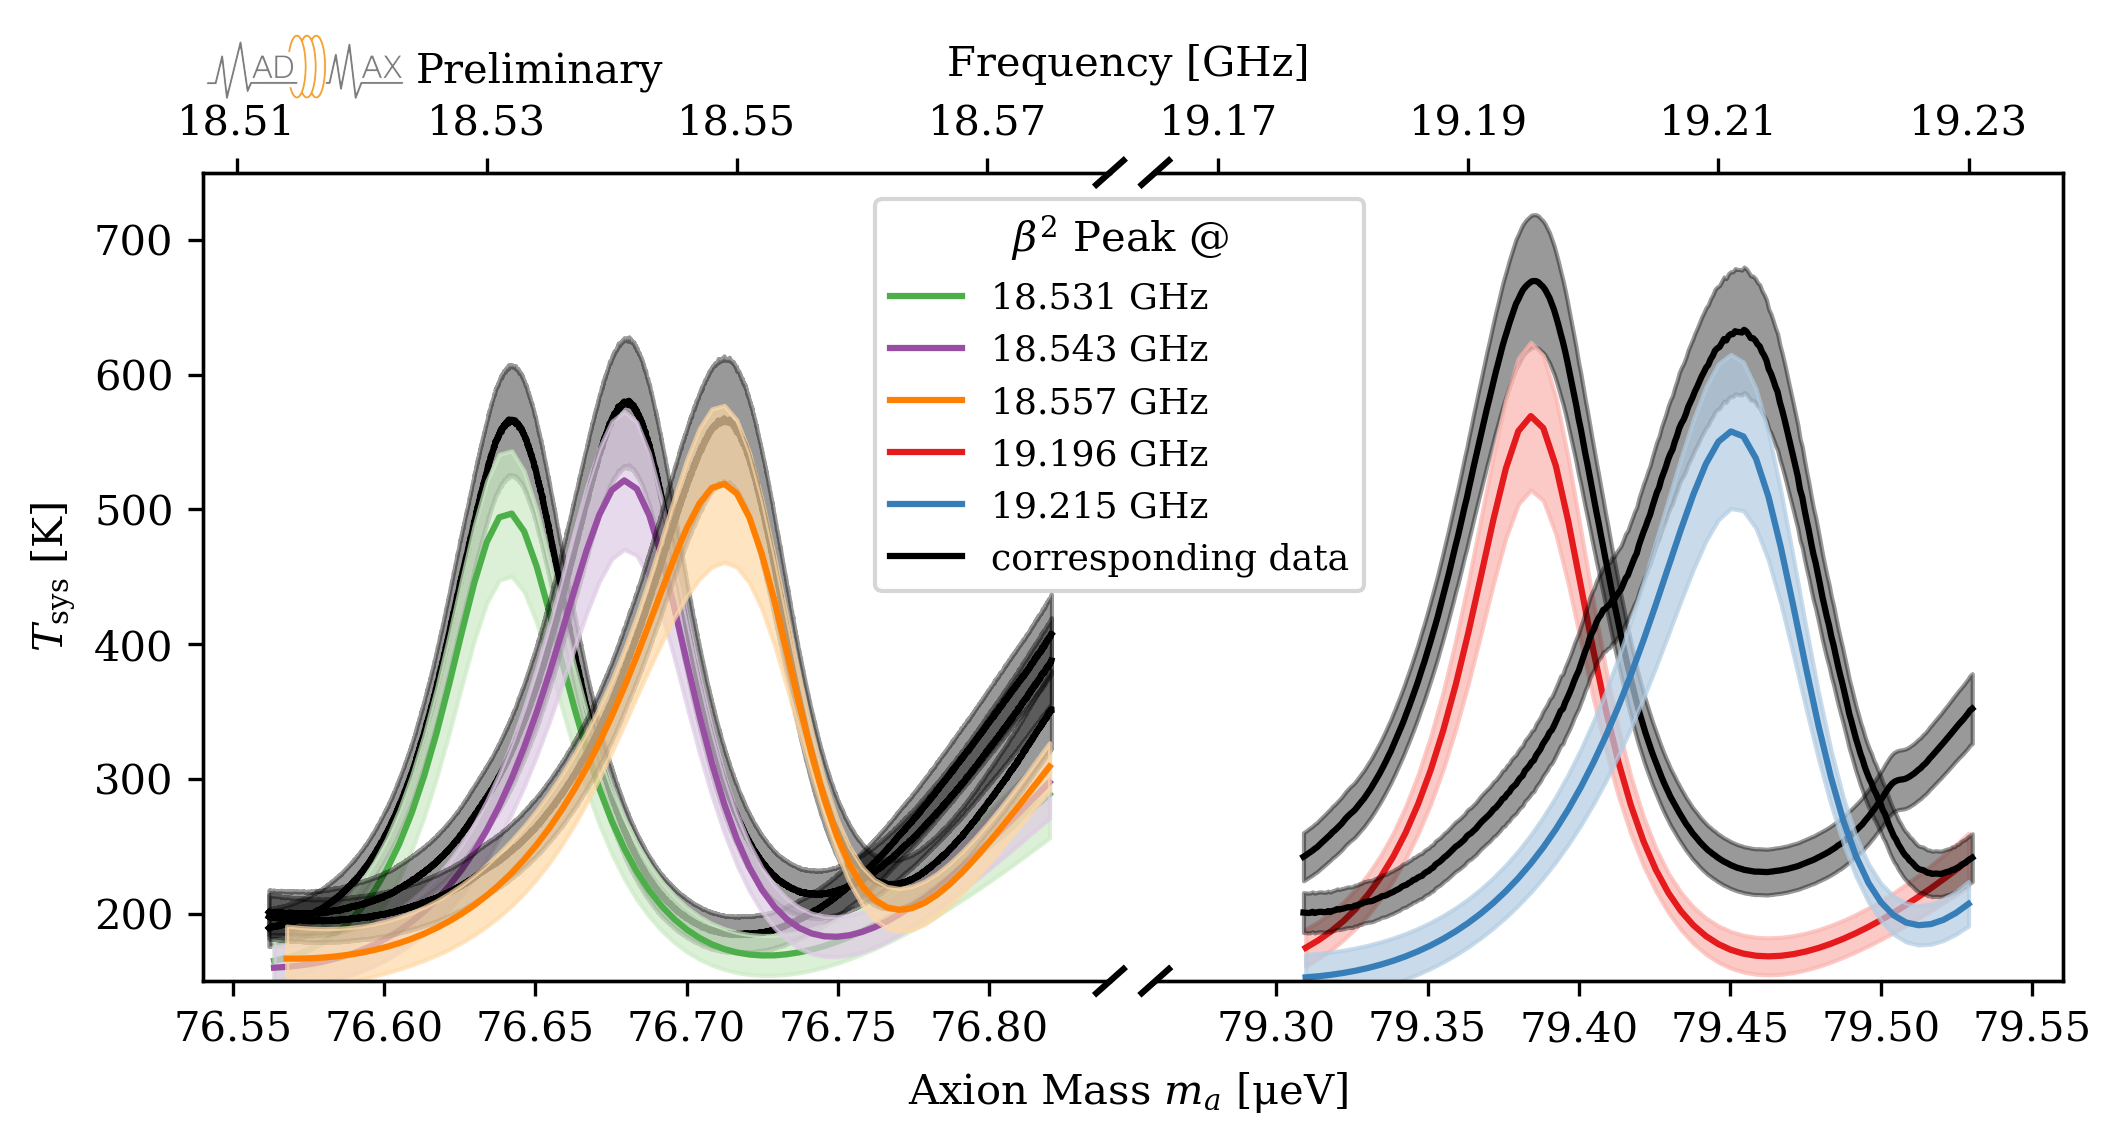

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
fig.subplots_adjust(wspace=0.05)

ax2.fill_between((mass.(te11["19.196 GHz"][:data_f][goodvalsh]) .* 1e6)[1:20:end], te11["19.196 GHz"][:data_mean][goodvalsh][1:20:end] .- te11["19.196 GHz"][:data_std][goodvalsh][1:20:end], te11["19.196 GHz"][:data_mean][goodvalsh][1:20:end] .+ te11["19.196 GHz"][:data_std][goodvalsh][1:20:end], alpha=0.4, label="", color="k", zorder=1)
ax2.plot((mass.(te11["19.196 GHz"][:data_f][goodvalsh]) .* 1e6)[1:20:end], te11["19.196 GHz"][:data_mean][goodvalsh][1:20:end], label="corresponding data", color="k", zorder=1)
ax2.fill_between((mass.(te11["19.215 GHz"][:data_f][goodvalsh]) .* 1e6)[1:20:end], te11["19.215 GHz"][:data_mean][goodvalsh][1:20:end] .- te11["19.215 GHz"][:data_std][goodvalsh][1:20:end],te11["19.215 GHz"][:data_mean][goodvalsh][1:20:end] .+ te11["19.215 GHz"][:data_std][goodvalsh][1:20:end], alpha=0.4, label="", color="k", zorder=2)
ax2.plot((mass.(te11["19.215 GHz"][:data_f][goodvalsh]) .* 1e6)[1:20:end], te11["19.215 GHz"][:data_mean][goodvalsh][1:20:end], label="", color="k", zorder=2)

ax1.fill_between((mass.(te11["18.532 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.532 GHz"][:data_mean][goodvalsl][1:20:end] .- te11["18.532 GHz"][:data_std][goodvalsl][1:20:end], te11["18.532 GHz"][:data_mean][goodvalsl][1:20:end] .+ te11["18.532 GHz"][:data_std][goodvalsl][1:20:end], alpha=0.4, label="", color="k", zorder=1)
ax1.plot((mass.(te11["18.532 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.532 GHz"][:data_mean][goodvalsl][1:20:end], label="", color="k", zorder=1)
ax1.fill_between((mass.(te11["18.543 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.543 GHz"][:data_mean][goodvalsl][1:20:end] .- te11["18.543 GHz"][:data_std][goodvalsl][1:20:end],  te11["18.543 GHz"][:data_mean][goodvalsl][1:20:end] .+ te11["18.543 GHz"][:data_std][goodvalsl][1:20:end], alpha=0.4, label="", color="k", zorder=1.5)
ax1.plot((mass.(te11["18.543 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.543 GHz"][:data_mean][goodvalsl][1:20:end], label="", color="k", zorder=1.5)
ax1.fill_between((mass.(te11["18.557 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.557 GHz"][:data_mean][goodvalsl][1:20:end] .- te11["18.557 GHz"][:data_std][goodvalsl][1:20:end],  te11["18.557 GHz"][:data_mean][goodvalsl][1:20:end] .+ te11["18.557 GHz"][:data_std][goodvalsl][1:20:end], alpha=0.4, label="", color="k", zorder=2)
ax1.plot((mass.(te11["18.557 GHz"][:data_f][goodvalsl]) .* 1e6)[1:20:end], te11["18.557 GHz"][:data_mean][goodvalsl][1:20:end], label="", color="k", zorder=2)

ax2.fill_between(mass.(te11["19.196 GHz"][:model_f][goodvalshm27]) .* 1e6, te11["19.196 GHz"][:model_mean][goodvalshm27] .- te11["19.196 GHz"][:model_std][goodvalshm27], te11["19.196 GHz"][:model_mean][goodvalshm27] .+ te11["19.196 GHz"][:model_std][goodvalshm27], alpha=0.7, label="", color=cmap(0), zorder=1)
ax2.plot(mass.(te11["19.196 GHz"][:model_f][goodvalshm27]) .* 1e6, te11["19.196 GHz"][:model_mean][goodvalshm27], label="$max27 GHz", color=cmap2(0), zorder=1)
ax2.fill_between(mass.(te11["19.215 GHz"][:model_f][goodvalshm23]) .* 1e6, te11["19.215 GHz"][:model_mean][goodvalshm23] .- te11["19.215 GHz"][:model_std][goodvalshm23],te11["19.215 GHz"][:model_mean][goodvalshm23] .+ te11["19.215 GHz"][:model_std][goodvalshm23], alpha=0.7, label="", color=cmap(1), zorder=2)
ax2.plot(mass.(te11["19.215 GHz"][:model_f][goodvalshm23]) .* 1e6, te11["19.215 GHz"][:model_mean][goodvalshm23], label="$max23 GHz", color=cmap2(1), zorder=2)

ax1.fill_between(mass.(te11["18.532 GHz"][:model_f][goodvalslm21]) .* 1e6, te11["18.532 GHz"][:model_mean][goodvalslm21] .- te11["18.532 GHz"][:model_std][goodvalslm21], te11["18.532 GHz"][:model_mean][goodvalslm21] .+ te11["18.532 GHz"][:model_std][goodvalslm21], alpha=0.7, label="", color=cmap(2), zorder=1)
ax1.plot(mass.(te11["18.532 GHz"][:model_f][goodvalslm21]) .* 1e6, te11["18.532 GHz"][:model_mean][goodvalslm21], label="$max21 GHz", color=cmap2(2), zorder=1)
ax1.fill_between(mass.(te11["18.543 GHz"][:model_f][goodvalslm29]) .* 1e6, te11["18.543 GHz"][:model_mean][goodvalslm29] .- te11["18.543 GHz"][:model_std][goodvalslm29],  te11["18.543 GHz"][:model_mean][goodvalslm29] .+ te11["18.543 GHz"][:model_std][goodvalslm29], alpha=0.7, label="", color=cmap(3), zorder=1.5)
ax1.plot(mass.(te11["18.543 GHz"][:model_f][goodvalslm29]) .* 1e6, te11["18.543 GHz"][:model_mean][goodvalslm29], label="$max29 GHz", color=cmap2(3), zorder=1.5)
ax1.fill_between(mass.(te11["18.557 GHz"][:model_f][goodvalslm05]) .* 1e6, te11["18.557 GHz"][:model_mean][goodvalslm05] .- te11["18.557 GHz"][:model_std][goodvalslm05],  te11["18.557 GHz"][:model_mean][goodvalslm05] .+ te11["18.557 GHz"][:model_std][goodvalslm05], alpha=0.7, label="", color=cmap(4), zorder=2)
ax1.plot(mass.(te11["18.557 GHz"][:model_f][goodvalslm05]) .* 1e6, te11["18.557 GHz"][:model_mean][goodvalslm05], label="$max05 GHz", color=cmap2(4), zorder=2)

h, l = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(vcat(h, h2[2:end], h2[1]),vcat(l, l2[2:end], l2[1]), loc="lower right", bbox_to_anchor=(0.25, 0.46), title=L"$\beta^2$ Peak @", fontsize=8.7)
ax1.set_xlabel(L"Axion Mass $m_a$ [$\mathrm{\mu}$eV]")
ax1.xaxis.set_label_coords(1.02, -0.11)
ax1.set_ylabel(L"$T_\mathrm{sys}$ [K]")
ax1.set_ylim((150, 750))
ax2.set_ylim((150, 750))

set_plot_params_CB200_configurations!(ax1, ax2; xstart=[76.54, 79.26])
MADMAX_inset(ax1; preliminary=true, loc=[-0.01,1.005,0.25,0.25])

plt.savefig("plots/spectra.pdf", bbox_inches="tight")
display(fig)

### Powerexcesses (Paper Fig. S7)

Before we can produce the plot we unfortunately need to re-run some parts of the pipeline. This might take a few minutes. We need knowledge of the expected signal power in each physics-run so we can combine them properly. For this we first need integration time which is easy to obtain via standard deviation of the processed spectra.

In [20]:
pp23, ff23 = get_processed_spectrum(phys23, window=1201, order=4, remove_peaks=-999, cut=1201÷2)
pp27, ff27 = get_processed_spectrum(phys27, window=1201, order=4, remove_peaks=-999, cut=1201÷2)

pp21, ff21 = get_processed_spectrum(phys21, window=1201, order=4, remove_peaks=-999, cut=1201÷2)
pp29, ff29 = get_processed_spectrum(phys29, window=1201, order=4, remove_peaks=-999, cut=1201÷2)
pp05, ff05 = get_processed_spectrum(phys05, window=1201, order=4, remove_peaks=-999, cut=1201÷2);

Using previously obtained boost factor and magnetic field data we can fill 'Experiment' structures with meaningful input.

In [21]:
betaquant23 = get_beta(beta23, method="mean")
B23, _ = adjust_times(B, phys23)
ex23 = SeedExperiment(pp23, B23, betaquant23, DateTime("2024-02-23T18:23:13"))

betaquant27 = get_beta(beta27, method="mean")
B27, _ = adjust_times(B, phys27)
ex27 = SeedExperiment(pp27, B27, betaquant27, DateTime("2024-02-27T15:23:27"))

betaquant21 = get_beta(beta21, method="mean")
B21, _ = adjust_times(B, phys21)
ex21 = SeedExperiment(pp21, B21, betaquant21, DateTime("2024-02-21T20:54:49"))

betaquant29 = get_beta(beta29, method="mean")
B29, _ = adjust_times(B, phys29)
ex29 = SeedExperiment(pp29, B29, betaquant29, DateTime("2024-03-05T10:32:34"))

betaquant05 = get_beta(beta05, method="mean")
B05, _ = adjust_times(B, phys05)
ex05 = SeedExperiment(pp05, B05, betaquant05, DateTime("2024-03-05T16:40:15"));

Now we can estimate the expected signal power for both configurations. This is used to scale the grand spectrum in order to obtain a physically somewhat meaningful y-axis.

In [22]:
EoN = 2240.92

Rglowf = gglowf.Rg .* (EoN/400.92)^2 .* (1 .- gulowf[1:end-234])
theories = [SeedTheory(ma=mass(gglowf.f[i]), EoverN=EoN) for i in 1:length(gglowf.f)]
sp05 = signal_power.(gglowf.f, theories, Ref(ex05))
sp21 = signal_power.(gglowf.f, theories, Ref(ex21))
sp29 = signal_power.(gglowf.f, theories, Ref(ex29))
sptotlowf = (sp05 .* length(names(phys05[!, Not(:f)])) .+ sp21 .* length(names(phys21[!, Not(:f)])) .+ sp29 .* length(names(phys29[!, Not(:f)]))) ./ (length(names(phys05[!, Not(:f)])) + length(names(phys21[!, Not(:f)])) + length(names(phys29[!, Not(:f)])))

EoN = 2165.92
Rghighf = gghighf.Rg .* (EoN/400.92)^2 .* (1 .- guhighf[1:end-234])
theories2 = [SeedTheory(ma=mass(gghighf.f[i]), EoverN=EoN) for i in 1:length(gghighf.f)]
sp23 = signal_power.(gghighf.f, theories2, Ref(ex23))
sp27 = signal_power.(gghighf.f, theories2, Ref(ex27))
sptothighf = (sp23 .* length(names(phys23[!, Not(:f)])) .+ sp27 .* length(names(phys27[!, Not(:f)]))) ./ (length(names(phys23[!, Not(:f)])) + length(names(phys27[!, Not(:f)])));

Finally, to the plot:

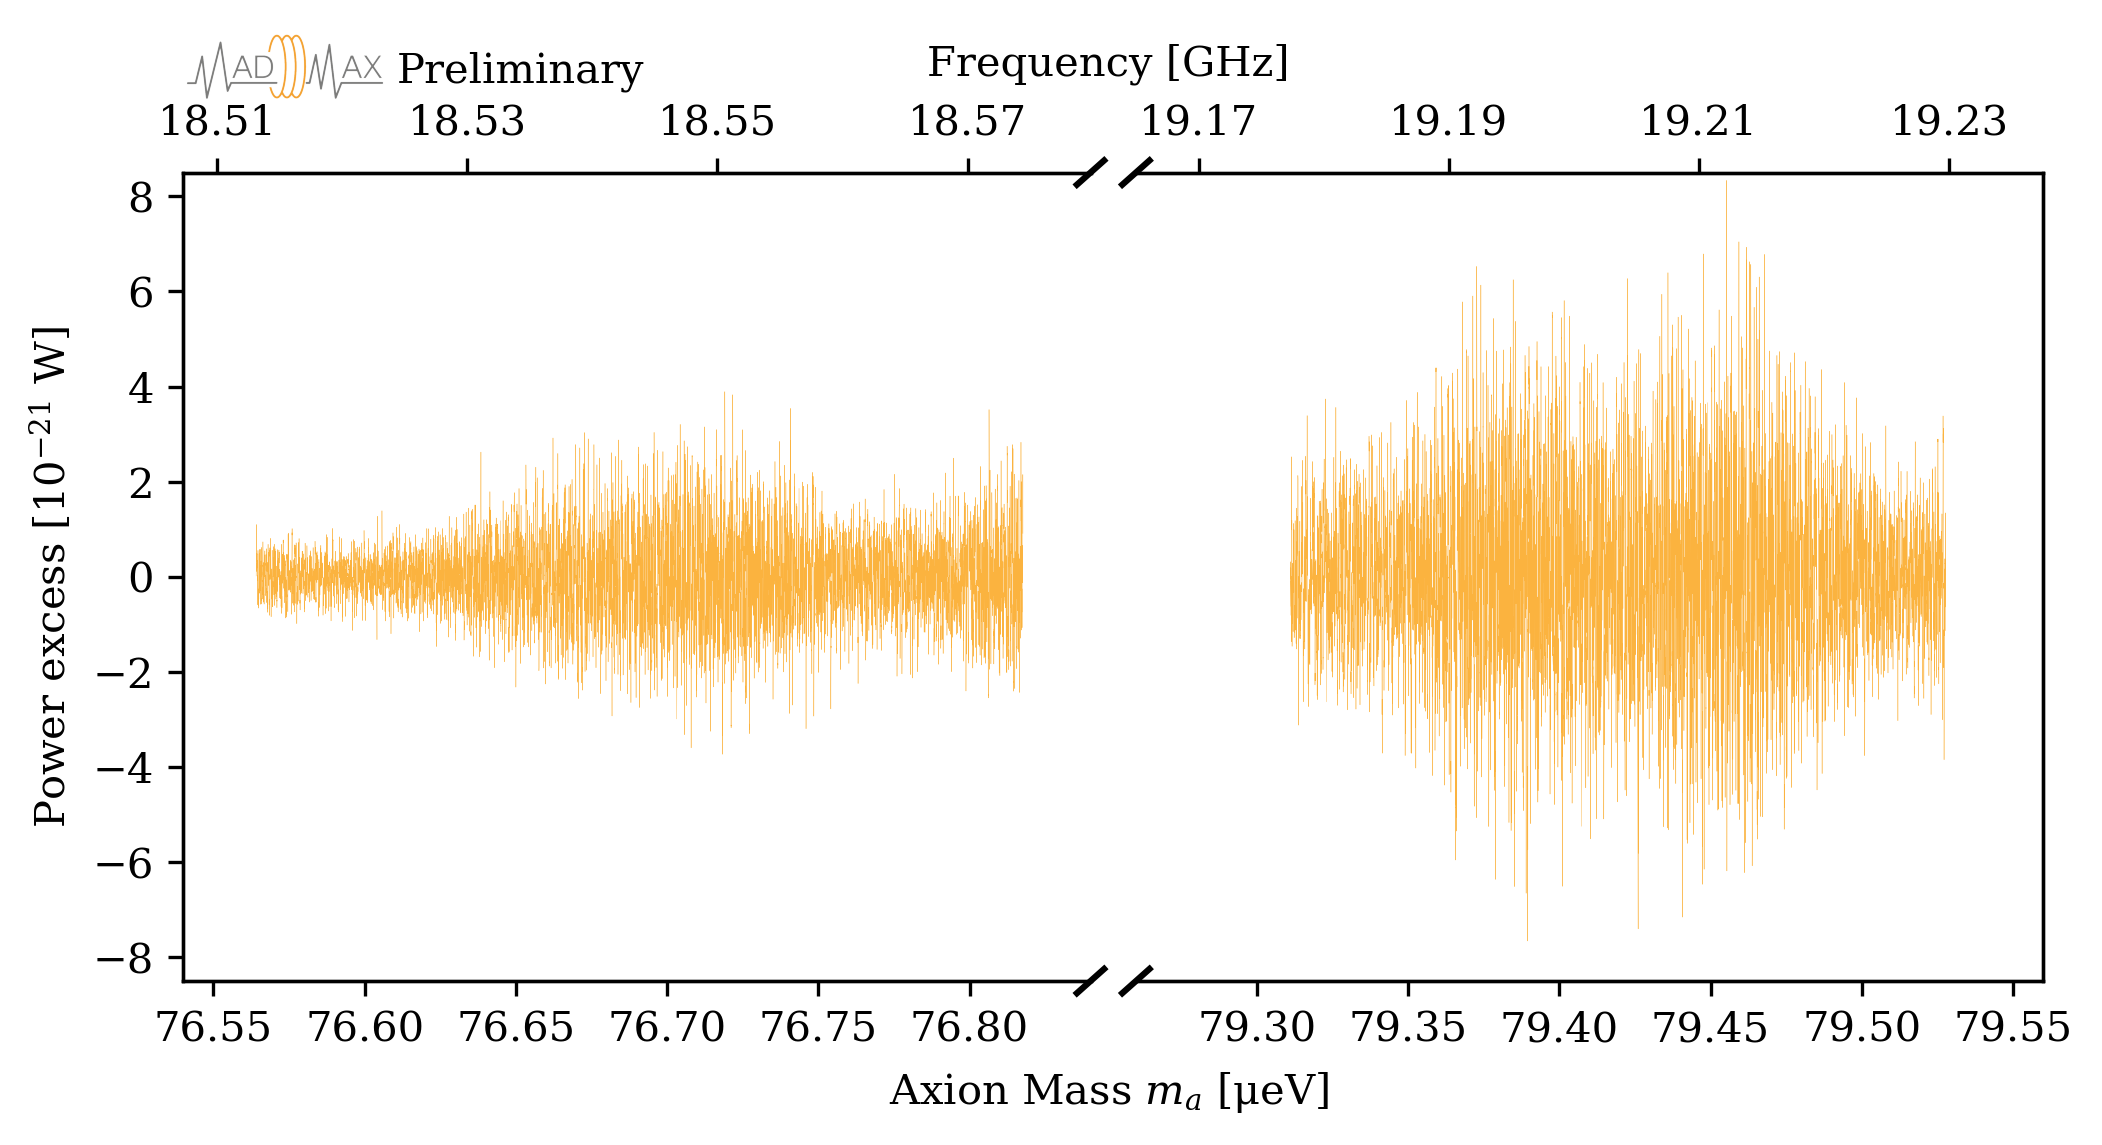

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5))
fig.subplots_adjust(wspace=0.05)

ax2.plot(mass.(gghighf.f) .* 1e6, 1e21 .* gghighf.grand .* sptothighf ./ Rghighf, label="", color=c1, zorder=1, lw=0.1)
ax1.plot(mass.(gglowf.f) .* 1e6, 1e21 .* gglowf.grand .* sptotlowf ./ Rglowf, label="cross-correlated power excess", color=c1, zorder=1, lw=0.1)

ax1.set_ylabel(L"Power excess [$10^{-21}$ W]")
ax1.set_ylim((-8.5, 8.5))
ax2.set_ylim((-8.5, 8.5))

set_plot_params_CB200_configurations!(ax1, ax2, xstart=[76.54, 79.26])
MADMAX_inset(ax1; preliminary=true, loc=[-0.01,1.005,0.25,0.25])

plt.savefig("plots/powexcesses.pdf", bbox_inches="tight")
display(fig)

### Zoom into limit (Paper Fig. S8)

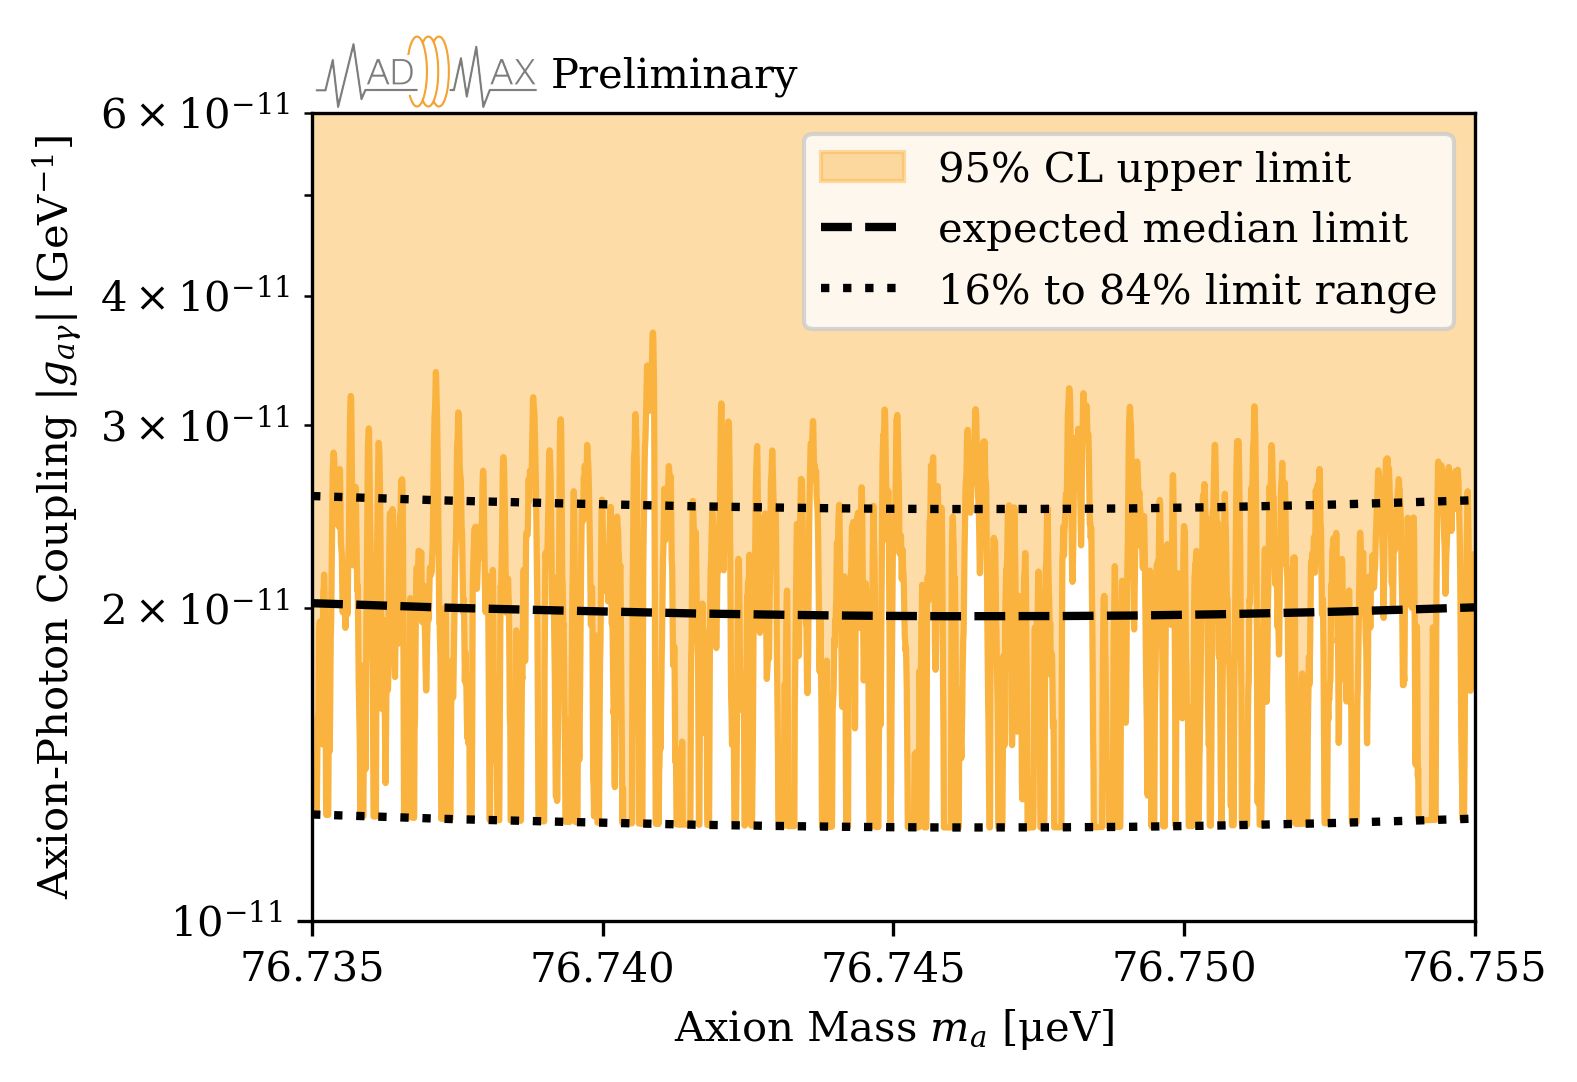

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
mlf = mass.(gglowf.f) .* 1e6
ax.fill_between(mlf, lllowf .* 1e9, 1e-9, alpha=0.45, label="95% CL upper limit", color=c1)
ax.plot(mlf, lllowf.* 1e9, label="", color=c1)
ax.plot(mlf, limit_median_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dashed, label="expected median limit")
ax.plot(mlf, limit_m1s_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="16% to 84% limit range")
ax.plot(mlf, limit_p1s_lf .* 1e9, lw=2, alpha=1, color=c2, ls=:dotted, label="")
ax.legend(loc="upper right", bbox_to_anchor=(0.50,0.297))
ax.set_yscale("log")
ax.set_xlabel(L"Axion Mass $m_a$ [$\mathrm{\mu}$eV]")
ax.set_ylabel(L"Axion-Photon Coupling $|g_{a\gamma}|\;[\mathrm{GeV}^{-1}]$")
ax.set_xlim((76.735, 76.755))
ax.set_xticks([76.735, 76.74, 76.745, 76.75, 76.755])
ax.set_ylim((1e-11, 6e-11))
ax.legend(loc="upper right")

MADMAX_inset(ax; preliminary=true, loc=[-0.01,0.94,0.22,0.22])

plt.savefig("plots/limitzoom.pdf", bbox_inches="tight")
display(fig)